In [7]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
%matplotlib inline
plt.style.use("seaborn")
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from scipy.signal import argrelextrema

### TODO
- Efficient
- clean
    - document
- extend residuals/predicted so can predict any date, not start and residuals divide by zero-padded array


In [8]:
data = pd.read_csv("./datasets/Metro_time_series.csv")

In [9]:
LAST_DATE = '2006'
cols = ['Date', 'RegionName', 'ZHVI_AllHomes']
data = data[data['ZHVI_AllHomes'] > 0]
data = data.filter(cols)
data = data.rename(columns={"RegionName": "CBSA_Code"})

cityList = np.unique(data['CBSA_Code'])
metro = []
for code in tqdm(cityList):
    if min(data[data['CBSA_Code']  == str(code)].Date.values) <= LAST_DATE:
        metro.append(data[data['CBSA_Code']  == str(code)])
metro

100%|██████████| 730/730 [00:23<00:00, 30.79it/s]


   47700       143000.0
 211139  2017-12-31     47700       144100.0
 
 [261 rows x 3 columns],
               Date CBSA_Code  ZHVI_AllHomes
 650     1996-04-30     47780        61300.0
 1337    1996-05-31     47780        61900.0
 2025    1996-06-30     47780        61500.0
 2714    1996-07-31     47780        60400.0
 3403    1996-08-31     47780        60000.0
 ...            ...       ...            ...
 207496  2017-08-31     47780       114000.0
 208407  2017-09-30     47780       114200.0
 209318  2017-10-31     47780       114400.0
 210229  2017-11-30     47780       114200.0
 211140  2017-12-31     47780       113800.0
 
 [261 rows x 3 columns],
               Date CBSA_Code  ZHVI_AllHomes
 651     1996-04-30     47900       154200.0
 1338    1996-05-31     47900       154200.0
 2026    1996-06-30     47900       154400.0
 2715    1996-07-31     47900       154500.0
 3404    1996-08-31     47900       154200.0
 ...            ...       ...            ...
 207498  2017-08-31   

In [13]:
from sklearn.preprocessing import StandardScaler

def standardize(metro):
    scaler = StandardScaler()
    train = metro.ZHVI_AllHomes.values.reshape(-1, 1)
    return scaler.fit_transform(train)

for i in tqdm(metro):
    i['ZHVI_std'] = standardize(i) 

100%|██████████| 653/653 [00:01<00:00, 447.25it/s]


In [5]:
#metro

In [6]:
def movingAverage_normalize(a, n=5) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    moving_avg = ret[n - 1:] / n
    return np.array([(x-np.mean(moving_avg))/np.std(moving_avg) for x in moving_avg])
#fig, ax = plt.subplots()
#ax.scatter(pd.to_datetime(city1['Date'][4:]).dt.date, movingAverage_normalize(city1['ZHVI_AllHomes'].values))
#plt.show()
movingAverage_normalize(city1['ZHVI_AllHomes'].values)
# don't send moving average 
#  CHECK IF AFFECTS MOVING AVERAGE AFFECTS ARIMA

NameError: name 'city1' is not defined

In [ ]:
city1 = metro[0]
ames = data[data.CBSA_Code == '29420']
print(ames)
fig, ax = plt.subplots()
ax.plot(pd.to_datetime(ames['Date'][4:]).dt.date, movingAverage_normalize(ames['ZHVI_AllHomes'].values))
# ax.scatter(pd.to_datetime('2009-05-31'), ames[ames['Date'] == '2009-05-31']['ZHVI_AllHomes'])

In [30]:
def find_start(city):
    """
    returns recession start date, measured as the largest local maximum ZHVI for a given city
    takes: city (pd.dataframe) [Date, ZHVI_avg_norm]
    returns: start_date (pd.datetime)
    """
    last_date = city.sort_values('Date', ascending=False).iloc[0]['Date']
    city = city[city['Date'] < '2015']
    d = lambda i: city['ZHVI_std'].iloc[i] - city['ZHVI_std'].iloc[i-1]
    diffs = np.array([d(i) for i in range(1, len(city))])
    # reshape dataframe to include diffs
    city = city.iloc[1:]
    city['Diffs'] = diffs
    # find local maxes using diffs
    is_max = np.array([(city['Diffs'].iloc[i] >= 0) 
                       and (city['Diffs'].iloc[i+1] <= 0) 
                       and (city['Diffs'].iloc[i+1] - city['Diffs'].iloc[i] <= THRESHOLD) for i in range(len(city) - 1)])
    is_max = np.append(is_max, False)

    # check for presence of local maxes at all
    if np.count_nonzero(is_max) == 0:
        return last_date
    # add 'is_maximum' truth column to dataframe
    city['Max'] = is_max

    recession_minimum_date = my_min(city)

    # filter and find largest max
    recession_max = city[(city['Max'] == 1.0) & (city['Date'] < recession_minimum_date)].sort_values("ZHVI_std", ascending=False).iloc[0]
    start_date = recession_max['Date']
    return start_date

In [22]:

def my_min(city_df, threshold=-0.002):
    THRESHOLD = threshold


    city_df = city_df[(city_df['Date'] > '2010-01-01') & (city_df['Date'] < '2015-01-01')]
    my_zhvi = city_df['ZHVI_std'].to_numpy()

    min_indeces = argrelextrema(my_zhvi, np.less)[0]
    min_vals = [my_zhvi[val] for val in min_indeces]
    min_dates = [city_df['Date'].to_numpy()[val] for val in min_indeces]


    curr_index = 0

    for i in range(len(min_vals)):
        if i == len(min_vals) - 1:
            curr_index = len(min_vals) - 1
            break
        else:
            if np.diff([min_vals[i], min_vals[i + 1]]) <= THRESHOLD: curr_index += 1
            else:
                curr_index = i
                break

    return min_dates[curr_index]

In [1]:
failed_cities = []
def ARIMA_50(city, start, params=(5,1,1)):
    """
    Params:
    city -- time-series dataframe object containing Date and ZHVI columns
    start -- datetime object from index of city representing peak ZHVI
    params -- p, d, and q parameters for ARIMA
    """
    
    #add start.dt.strftime('%Y-%m-%d') to convert datetime to string
    
    from statsmodels.tsa.arima_model import ARIMA
    
    before = city[['Date', 'ZHVI_std']]
#     print(before.shape, start)
    before = before[before['Date'] < start].set_index(['Date'])['ZHVI_std'].values
    steps = city.shape[0] - before.shape[0]
    try:
        model = ARIMA(before, order=(5, 1, 1))
        model_fit = model.fit(disp=0)
        return model_fit.forecast(steps)[0]
    except:
        failed_cities.append(np.unique(city.CBSA_Code)[0])
        return np.repeat(city[city['Date'] == start].ZHVI_AllHomes, steps)


In [3]:
def find_end(city, start, ARIMA_50):
    """
    returns recession end date, measured as the first point of intersection between ZHVI and ARIMA_50 for a given city
    takes: city (pd.dataframe) [Date, ZHVI_avg_norm], ARIMA_50 (pd.dataframe) [Date, forecasted_ZHVI_norm] 
    returns: end_date (pd.datetime)
    """
    # calculate diffs
    recession_ZHVI = city[city['Date'] >= start]
    diffs = ARIMA_50 - recession_ZHVI['ZHVI_std'].values
    city_resid = pd.DataFrame(data={'Date': recession_ZHVI['Date'].values, 'Delta': diffs})
    # filter only positive residuals, and most recent one is the last recession date
    most_recent_positive_delta = city_resid[city_resid['Delta'] > 0].sort_values("Date", ascending=False)
   # if ARIMA model indicates a sharp drop, set end date as one month after start date
    if (most_recent_positive_delta.shape[0] == 0):
        return city_resid.Date.values[0]
    end_date = most_recent_positive_delta['Date'].iloc[0]
#     print(end_date)
    return end_date

In [4]:
def calc_resid(city, predicted, start, end):
    """
    Params:
    city -- time-series dataframe object containing Date and ZHVI columns
    predicted -- predicted values from max to last date of city time-series
    max -- datetime object from index of city representing peak ZHVI
    end -- datetime object from index of city representing intersection of 
    actual and predicted ZHVI or last date of actual
    """
    
    # get indices of start and end date and use those to splice arrays
    recession_ZHVI = city[city['Date'] >= start]
    recession_ZHVI = recession_ZHVI[recession_ZHVI['Date'] < end]
    end_index = len(recession_ZHVI)
    predicted_to_end = predicted[:end_index]
    diffs = predicted_to_end - recession_ZHVI['ZHVI_std'].values
    return sum(diffs)

In [5]:
def find_AU3(metro):
#     print("City: {}".format(np.unique(metro.CBSA_Code)))
    start = find_start(metro)
    arima = ARIMA_50(metro, start)
    print("Start Date: ", start)
#     fig, ax = plt.subplots()
#     ax.plot(pd.to_datetime(metro['Date'][4:]).dt.date, movingAverage_normalize(metro['ZHVI_AllHomes'].values))
#     print(metro[metro['Date'] > start].shape)
    end = find_end(metro, start, arima)
    print("End Date: ", end)
    return calc_resid(metro, arima, start, end)

In [36]:
#metro[0]
find_AU3(metro[1])

48.13812915827829

In [32]:
AU3_output = list(map(find_AU3, tqdm(metro)))

3%|▎         | 19/653 [00:14<08:36,  1.23it/s]/home/freebreadstix/.local/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
  5%|▌         | 34/653 [00:26<08:34,  1.20it/s]/home/freebreadstix/.local/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
  6%|▋         | 42/653 [00:32<07:33,  1.35it/s]/home/freebreadstix/.local/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
/home/freebreadstix/.local/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn(

In [35]:
failed_cities

['11020',
 '13020',
 '13060',
 '13940',
 '14220',
 '14780',
 '16180',
 '16260',
 '17200',
 '21740',
 '25060',
 '28500',
 '28780',
 '29420',
 '29500',
 '30060',
 '32620',
 '32860',
 '34140',
 '35840',
 '39500',
 '40180',
 '41760',
 '43940',
 '46860',
 '48460']

(17.988555616184318, -4.152091824283903)

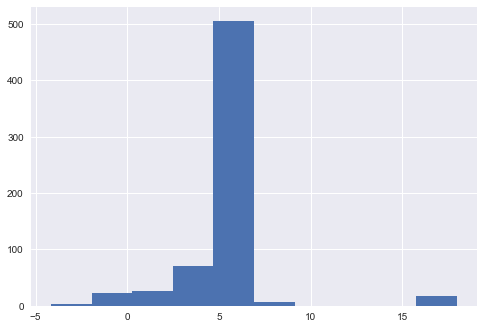

In [48]:
adjusted_outputs = [np.log(i) if i > 0 else i for i in np.abs(AU3_output)]
plt.hist(adjusted_outputs)
max(adjusted_outputs), min(adjusted_outputs)

In [49]:
cbsa_codes = [m['CBSA_Code'].iloc[0] for m in metro]

final_metro = pd.DataFrame(data={"CBSA_Codes": cbsa_codes, "AU3": adjusted_outputs})
final_metro.to_csv("AU3_results.csv")

In [50]:
final_metro.sort_values('AU3', ascending=True)

,CBSA_Codes,AU3
424,36420,-4.152092
222,23780,-3.721457
336,30700,-3.098149
427,36540,-2.414623
162,19780,-1.871264
...,...,...
114,17200,17.364266
519,41760,17.449039
77,14780,17.597436
605,46860,17.735015


In [26]:
final_metro.sort_values('AU3', ascending=False)

,CBSA_Codes,AU3
95,16180,17.988556
605,46860,17.735015
77,14780,17.597436
519,41760,17.449039
114,17200,17.364266
...,...,...
162,19780,-1.871264
427,36540,-2.414623
336,30700,-3.098149
222,23780,-3.721457


In [36]:
df = pd.DataFrame({"Date": [], "CBSA_Code": [], "ZHVI_AllHomes": [], "ZHVI_std": []})
for i in tqdm(metro):
    df = df.append(i)

100%|██████████| 653/653 [00:03<00:00, 198.30it/s]


In [37]:
df.to_csv("./datasets/normed_ZHVI.csv")

## Everything below this cell is experimental/debugging

In [ ]:
# RANDOM STUFF DELETE LATER

from statsmodels.tsa.arima_model import ARIMA
city1.tail()
before = city1[['Date', 'ZHVI_AllHomes']][city1['Date'] < '2017-08-31'].set_index(['Date'])['ZHVI_AllHomes']
model = ARIMA(endog=np.array(before, dtype=np.float), order=(5, 1, 1))
model_fit = model.fit(disp=0)
#np.array(before, dtype=np.float)[0]
#city1['dt'] = city1
#np.array(city1['Date'], dtype='datetime64')
model_fit.predict(before.shape[0], city1.shape[0])

In [ ]:
city1 = city1[city1['Date'] < "2012"]
d = lambda i: city1['ZHVI_AllHomes'].iloc[i] - city1['ZHVI_AllHomes'].iloc[i-1]
diffs = np.array([d(i) for i in range(1, len(city1))])
# reshape dataframe to include diffs
city1 = city1.iloc[1:]
city1['Diffs'] = diffs
city1['Diffs']
# find local maxes using diffs
is_max = np.array([(city1['Diffs'].iloc[i] >= 0) and (city1['Diffs'].iloc[i+1] <= 0) for i in range(len(city1) - 1)])
is_max = np.append(is_max, False)

# check for presence of local maxes at all
if np.count_nonzero(is_max) == 0:
    print(0)
# add 'is_maximum' truth column to dataframe
city1['Max'] = is_max
# filter and find largest max
theMax = city1[city1['Max'] == 1.0].sort_values("ZHVI_AllHomes", ascending=False).iloc[0]
start_date = theMax['Date']
start_date

In [21]:
city1

,Date,CBSA_Code,ZHVI_AllHomes,ZHVI_std
15439,1998-02-28,10140,80100.0,-1.632786
16171,1998-03-31,10140,81100.0,-1.581558
16903,1998-04-30,10140,83000.0,-1.484225
17637,1998-05-31,10140,84500.0,-1.407382
18371,1998-06-30,10140,85500.0,-1.356154
...,...,...,...,...
206628,2017-08-31,10140,147100.0,1.799503
207539,2017-09-30,10140,148800.0,1.886591
208450,2017-10-31,10140,150000.0,1.948065
209361,2017-11-30,10140,151400.0,2.019784


In [31]:
# Lucas

city1 = metro[0]
#find_AU3(city1)
find_AU3(city1)


276.5000888781456